# PyTorch dataset creation

Split `train_metadata_subset.csv` into train and test, in stratified fashion

In [1]:
!pip3 install albumentations

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import random

img_labels = pd.read_csv(Path("data") / "train_metadata_subset.csv")
print(len(img_labels))


def filter(dataframe, key, lb, yes, no):
    for i, k in enumerate(dataframe[key].tolist()):
        if lb(k):
            yes.loc[len(yes)] = dataframe.loc[i]
        else:
            if no is not None:
                no.loc[len(no)] = dataframe.loc[i]

train = pd.DataFrame(columns=['image', 'cultivar'])
test = pd.DataFrame(columns=['image', 'cultivar'])
img_to_split = pd.DataFrame(columns=['image', 'cultivar'])

# isolate all class with only 1 training sample and put them in train
counts = img_labels['cultivar'].value_counts()
print(counts)
filter(img_labels, 'cultivar', lambda cultivar: counts[cultivar] == 1, train, img_to_split)

imgs = img_to_split['image'].tolist()
labels = img_to_split['cultivar'].tolist()

print(len(imgs), len(labels))

train_split, test_split = train_test_split(imgs, test_size=0.38, stratify=labels)
print('train', train_split)
print('test_split', test_split, len(test_split))

filter(img_to_split, 'image', lambda image: image in train_split, train, test)

print('train', train)
print('test', test)

assert(len(img_labels) == len(train) + len(test))

train.to_csv(Path('data') / 'train.csv', index=False)
test.to_csv(Path('data') / 'test.csv', index=False)

165
PI_52606     6
PI_196049    5
PI_175919    5
PI_273969    4
PI_329333    4
            ..
PI_154750    1
PI_152727    1
PI_329301    1
PI_267573    1
PI_297171    1
Name: cultivar, Length: 83, dtype: int64
133 133
train ['2017-06-27__10-33-52-663.png', '2017-06-15__12-16-02-755.png', '2017-06-01__12-05-25-739.png', '2017-06-23__12-44-08-451.png', '2017-06-26__10-34-30-574.png', '2017-06-03__11-47-12-396.png', '2017-06-19__18-06-32-112.png', '2017-06-13__11-24-42-895.png', '2017-06-03__12-47-23-312.png', '2017-06-28__11-50-22-395.png', '2017-06-21__13-02-59-731.png', '2017-06-01__12-03-11-225.png', '2017-06-13__11-28-55-689.png', '2017-06-13__12-34-28-998.png', '2017-06-18__14-41-59-638.png', '2017-06-01__12-42-56-491.png', '2017-06-28__10-55-20-476.png', '2017-06-20__12-22-46-212.png', '2017-06-01__11-37-11-574.png', '2017-06-22__13-18-06-841.png', '2017-06-13__11-39-32-692.png', '2017-06-02__17-58-56-793.png', '2017-06-01__11-17-06-111.png', '2017-06-16__11-29-50-833.png', '2017-0

In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype

class CultivarDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])

        # NOTE: when pytorch reads an image, it is immediately transformed into a uint8 Tensor with each channel ranging in [0, 255]
        image = read_image(img_path)

        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transforms to consider and cross-validate:
- (Random) equalization
    - should it even be random?
- Color jitter in terms of:
    - Brightness
    - Contrast
    - Hue
    - Saturation
- Random rotation
- Random crop
- The order in which these functions are composed

In [4]:
import torchvision.transforms as T

# mean and std of each color channel
# below is that of imagenet 
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

Outdated

In [5]:
# DO NOT USE THIS FOR TRAINING! THIS IS SOLELY USED TO VISUALIZE THE EFFECT OF TRANSFORMATIONS.
training_data_vis = CultivarDataset(
    annotations_file="data/train_metadata_subset.csv",
    img_dir="data/train_images",
    transform=T.Compose([
        T.RandomEqualize(p=1),
        T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
        T.ColorJitter(brightness=.2, contrast=0),
        T.RandomCrop(size=(500, 500)),
        T.RandomRotation(degrees=(-180, 180)),
        T.CenterCrop(size=(224, 224))
    ])
)

training_data = CultivarDataset(
    annotations_file="data/train_metadata_subset.csv",
    img_dir="data/train_images",
    transform=T.Compose([
        T.RandomEqualize(p=1),
        T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
        # T.ColorJitter(brightness=.5, contrast=.7),
        T.RandomCrop(size=(500, 500)),
        T.RandomRotation(degrees=(-180, 180)),
        T.CenterCrop(size=(224, 224)),
        T.Normalize(norm_mean, norm_std)
    ])
)

Use this instead

In [34]:

# DO NOT USE THIS FOR TRAINING! THIS IS SOLELY USED TO VISUALIZE THE EFFECT OF TRANSFORMATIONS.
training_data_vis = CultivarDataset(
    annotations_file="data/train_metadata_subset.csv",
    img_dir="data/train_images",
    transform=T.Compose([
        T.RandomEqualize(p=1),
        T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
        T.RandomRotation(degrees=(-15, 15)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.Resize(size=(224, 224))
    ])
)

# USE THIS INSTEAD
training_data = CultivarDataset(
    annotations_file=annotation_file_path,
    img_dir=img_dir_path,
    transform=T.Compose([
        T.RandomEqualize(p=1),
        T.ConvertImageDtype(torch.float), # we are given uint8 tensor, but we need a float tensor
        # T.ColorJitter(brightness=.5, contrast=.7),
        T.RandomRotation(degrees=(-15, 15)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.Resize(size=(224, 224)),
        T.Normalize(norm_mean, norm_std)
    ])
)

What the transform does to individual images (uses uint8, before normalization)

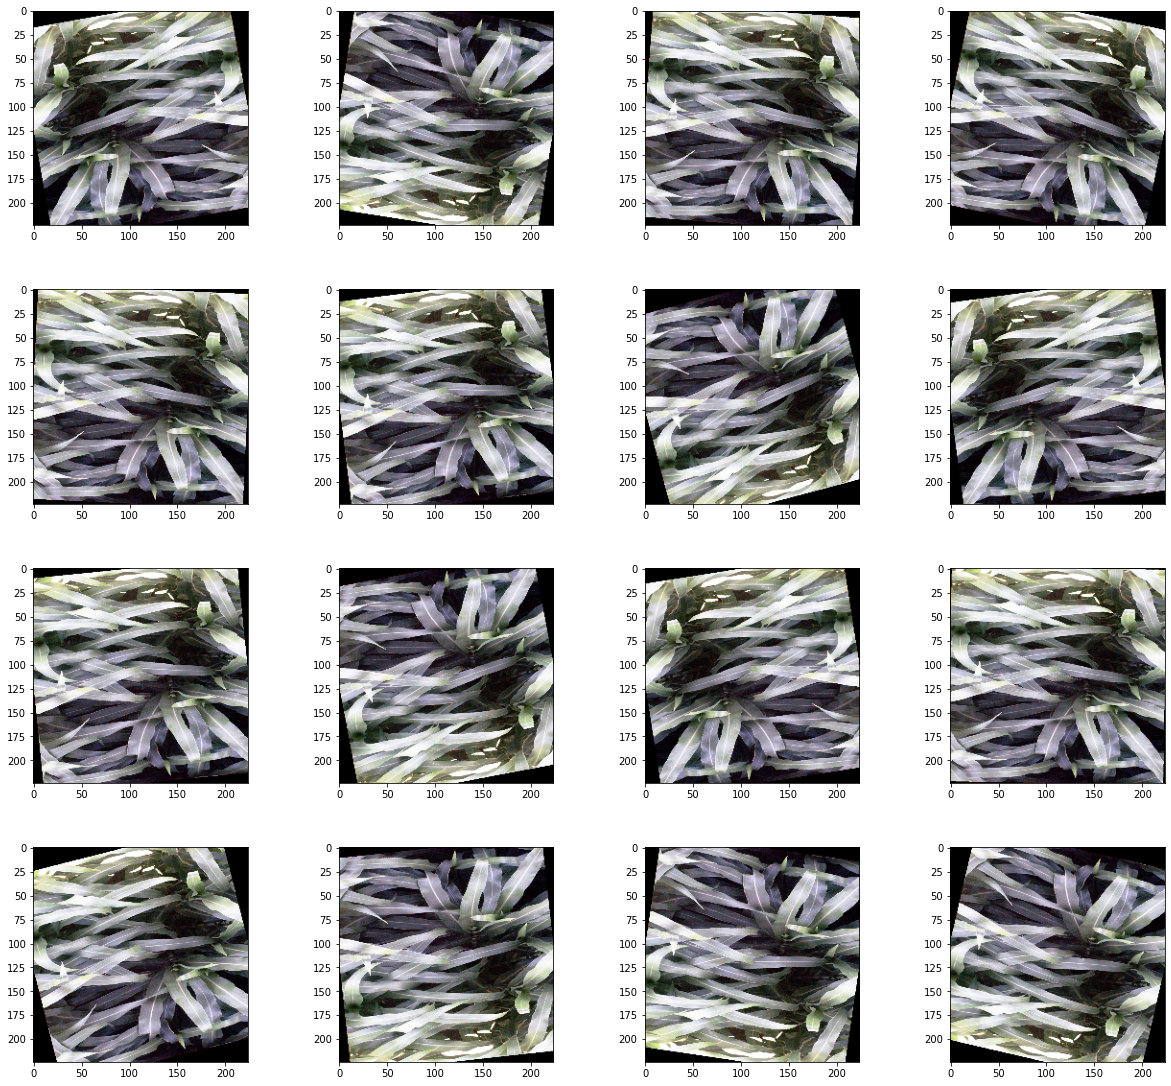

In [7]:
import matplotlib.pyplot as plt
from numpy import transpose

figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 4
plt.subplots_adjust(left=0.13, right=0.93, top=1.0, bottom= 0.27, wspace= 0.3, hspace=0.3)
for i in range(1, cols * rows + 1):
    # sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample_idx = 0
    img, label = training_data_vis[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(transpose(img.numpy(), (1,2,0)))
plt.show()


Visualize just the red channel, after normalization (uses float)

In [35]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 4
plt.subplots_adjust(left=0.13, right=0.93, top=1.0, bottom= 0.27, wspace= 0.3, hspace=0.3)
for i in range(1, cols * rows + 1):
    # sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample_idx = 0
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze()[0])
    plt.colorbar()
plt.show()


TypeError: HueSaturationValue transformation expects 1-channel or 3-channel images.

<Figure size 1440x1440 with 0 Axes>

Effect on random different images in the dataset 

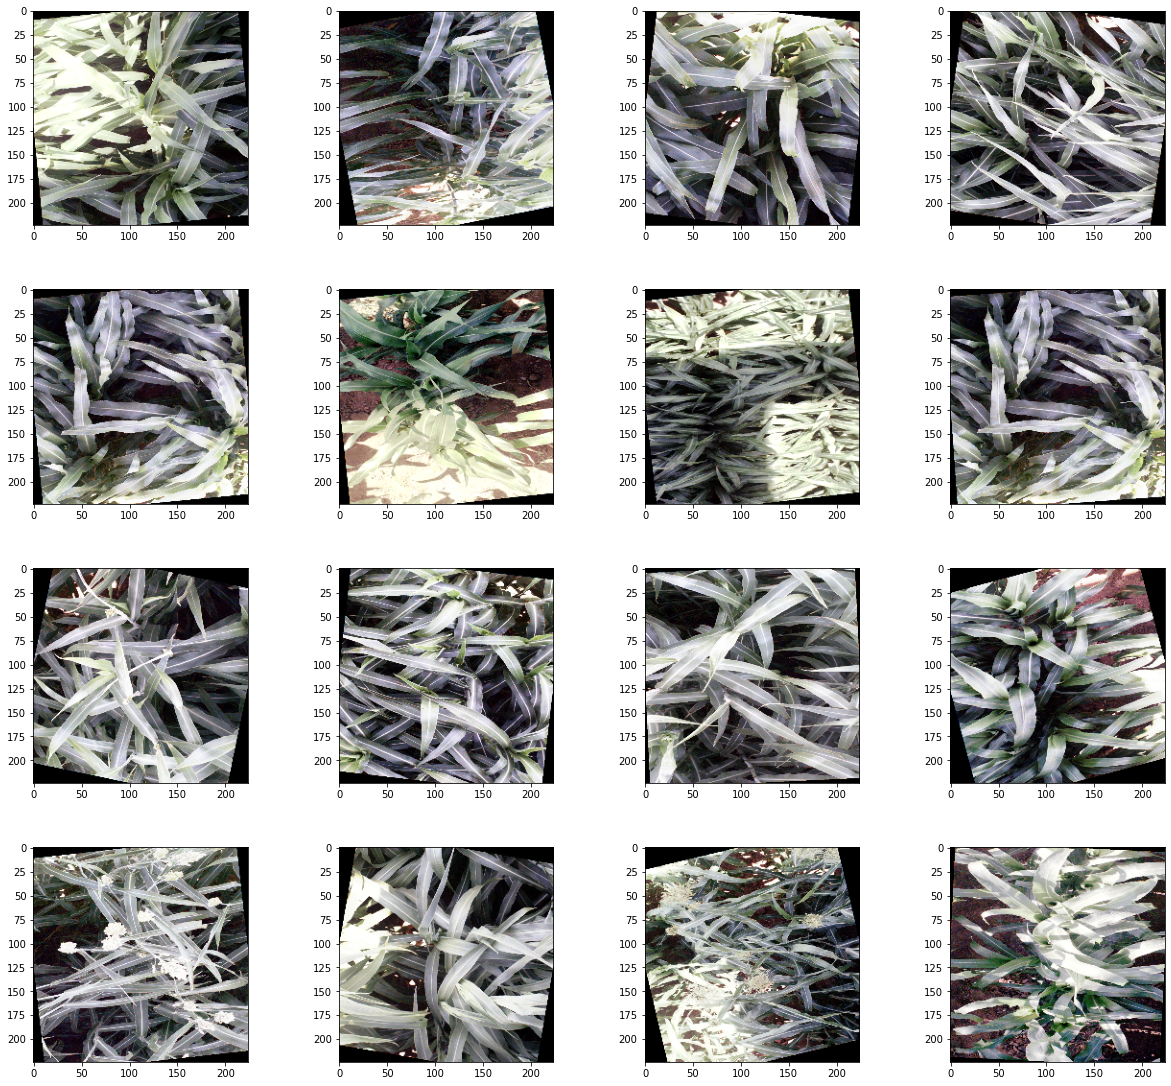

In [ ]:
import matplotlib.pyplot as plt
from numpy import transpose

figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 4
plt.subplots_adjust(left=0.13, right=0.93, top=1.0, bottom= 0.27, wspace= 0.3, hspace=0.3)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data_vis[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(transpose(img.numpy(), (1,2,0)))
plt.show()

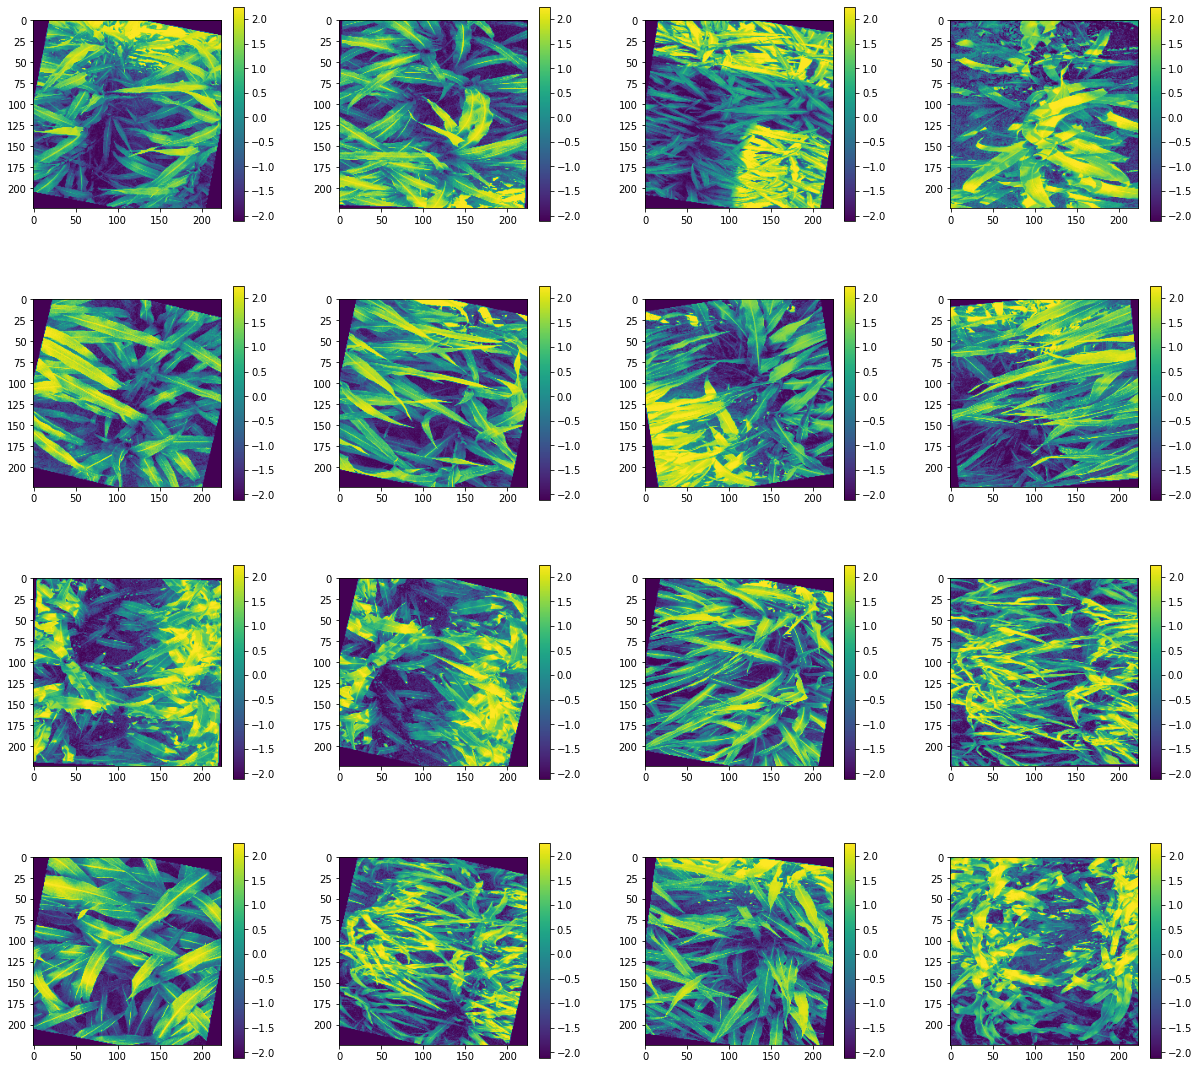

In [ ]:
figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 4
plt.subplots_adjust(left=0.13, right=0.93, top=1.0, bottom= 0.27, wspace= 0.3, hspace=0.3)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze()[0])
    plt.colorbar()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d841b2e3-7f2f-42e6-ae8e-6cea1c0a3631' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>